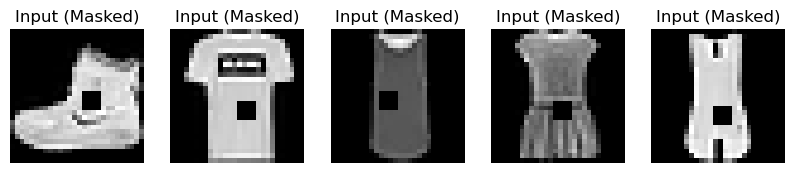

1/1 [==============================] - 0s 113ms/step
Epoch 1/500, Discriminator Loss: 0.6902552247047424, Generator Loss: 0.6921460628509521
1/1 [==============================] - 0s 24ms/step
Epoch 2/500, Discriminator Loss: 0.6473065614700317, Generator Loss: 0.6865937113761902
1/1 [==============================] - 0s 21ms/step
Epoch 3/500, Discriminator Loss: 0.6151310205459595, Generator Loss: 0.6754145622253418
1/1 [==============================] - 0s 23ms/step
Epoch 4/500, Discriminator Loss: 0.5920946598052979, Generator Loss: 0.66205894947052
1/1 [==============================] - 0s 23ms/step
Epoch 5/500, Discriminator Loss: 0.5836859941482544, Generator Loss: 0.6536868810653687
1/1 [==============================] - 0s 25ms/step
Epoch 6/500, Discriminator Loss: 0.569575309753418, Generator Loss: 0.6650443077087402
1/1 [==============================] - 0s 28ms/step
Epoch 7/500, Discriminator Loss: 0.5529525279998779, Generator Loss: 0.7007143497467041
1/1 [=================

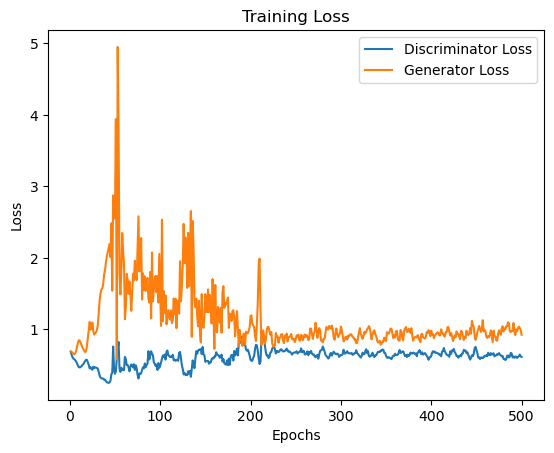

1/1 [==============================] - 0s 170ms/step


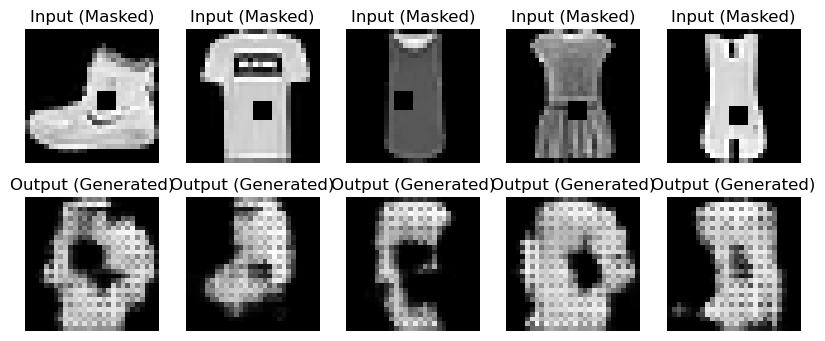

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Flatten, Dense, Reshape, LeakyReLU, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Load Fashion MNIST dataset
(train_images, _), (_, _) = fashion_mnist.load_data()

# Normalize images to range [-1, 1]
train_images = (train_images.astype('float32') - 127.5) / 127.5
train_images = np.expand_dims(train_images, axis=-1)

# Mask some random central regions in images for inpainting
mask_value = -1.0
mask_size = 4
masked_images = np.copy(train_images)
for i in range(len(masked_images)):
    x = np.random.randint(10, 18)
    y = np.random.randint(10, 18)
    masked_images[i, x:x+mask_size, y:y+mask_size, :] = mask_value

# Visualize some masked images
n_samples = 5
plt.figure(figsize=(10, 4))
for i in range(n_samples):
    plt.subplot(2, n_samples, i + 1)
    plt.imshow(masked_images[i, :, :, 0], cmap='gray')
    plt.title('Input (Masked)')
    plt.axis('off')
plt.show()

# Define the input shape
input_shape = (28, 28, 1)

# Encoder
encoder_input = Input(shape=input_shape)
x = Conv2D(32, kernel_size=3, strides=2, padding='same', activation='relu')(encoder_input)
x = Conv2D(64, kernel_size=3, strides=2, padding='same', activation='relu')(x)
x = Flatten()(x)
encoder_output = Dense(64)(x)  # Latent space representation
encoder = Model(encoder_input, encoder_output, name='Encoder')

# Generator (Decoder)
latent_input = Input(shape=(64,))
x = Dense(7*7*64, activation='relu')(latent_input)
x = Reshape((7, 7, 64))(x)
x = Conv2DTranspose(64, kernel_size=3, strides=2, padding='same', activation='relu')(x)
x = Conv2DTranspose(32, kernel_size=3, strides=2, padding='same', activation='relu')(x)
decoder_output = Conv2DTranspose(1, kernel_size=3, padding='same', activation='tanh')(x)
generator = Model(latent_input, decoder_output, name='Generator')

# Discriminator
image_input = Input(shape=input_shape)
x = Conv2D(32, kernel_size=3, strides=2, padding='same', activation='relu')(image_input)
x = Conv2D(64, kernel_size=3, strides=2, padding='same', activation='relu')(x)
x = Flatten()(x)
discriminator_output = Dense(1, activation='sigmoid')(x)
discriminator = Model(image_input, discriminator_output, name='Discriminator')

# Compile discriminator
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5), metrics=['accuracy'])

# Combined GAN model
discriminator.trainable = False
gan_input = Input(shape=(64,))
gan_output = discriminator(generator(gan_input))
gan = Model(gan_input, gan_output, name='GAN')

# Compile GAN
gan.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))

# Training parameters
batch_size = 32
epochs = 500

# Lists to store loss values
discriminator_losses = []
generator_losses = []

# Training loop
for epoch in range(epochs):
    # Sample random noise
    noise = np.random.normal(0, 1, (batch_size, 64))
    
    # Generate images
    generated_images = generator.predict(noise)
    
    # Select a random batch of real images
    real_images = masked_images[np.random.randint(0, masked_images.shape[0], batch_size)]
    
    # Concatenate real images with generated images
    X = np.concatenate([real_images, generated_images])
    
    # Labels for generated and real images
    y_dis = np.zeros(2*batch_size)
    y_dis[:batch_size] = 0.9  # Label smoothing
    
    # Train discriminator
    discriminator_loss = discriminator.train_on_batch(X, y_dis)
    discriminator_losses.append(discriminator_loss[0])
    
    # Train generator
    noise = np.random.normal(0, 1, (batch_size, 64))
    y_gen = np.ones(batch_size)
    generator_loss = gan.train_on_batch(noise, y_gen)
    generator_losses.append(generator_loss)
    
    # Print progress
    print(f'Epoch {epoch+1}/{epochs}, Discriminator Loss: {discriminator_loss[0]}, Generator Loss: {generator_loss}')

# Plot loss curves
plt.plot(range(1, epochs+1), discriminator_losses, label='Discriminator Loss')
plt.plot(range(1, epochs+1), generator_losses, label='Generator Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss')
plt.show()

# Generate and visualize images
n_samples = 5
noise = np.random.normal(0, 1, (n_samples, 64))
generated_images = generator.predict(noise)

plt.figure(figsize=(10, 4))
for i in range(n_samples):
    plt.subplot(2, n_samples, i + 1)
    plt.imshow(masked_images[i, :, :, 0], cmap='gray')
    plt.title('Input (Masked)')
    plt.axis('off')
    plt.subplot(2, n_samples, n_samples + i + 1)
    plt.imshow(generated_images[i, :, :, 0], cmap='gray')
    plt.title('Output (Generated)')
    plt.axis('off')
plt.show()


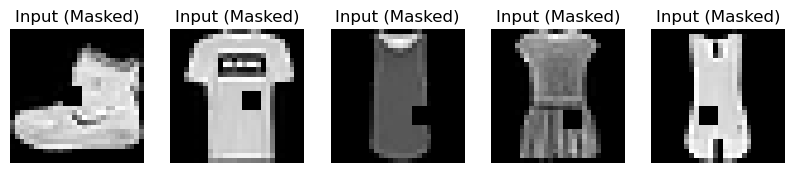

4/4 [==============================] - 0s 8ms/step
Epoch 1/5000, Discriminator Loss: 0.6964373588562012, Generator Loss: 0.6916582584381104
4/4 [==============================] - 0s 7ms/step
Epoch 2/5000, Discriminator Loss: 0.6460970640182495, Generator Loss: 0.6847783327102661
4/4 [==============================] - 0s 7ms/step
Epoch 3/5000, Discriminator Loss: 0.6093173623085022, Generator Loss: 0.6764429211616516
4/4 [==============================] - 0s 7ms/step
Epoch 4/5000, Discriminator Loss: 0.5840957164764404, Generator Loss: 0.6751821041107178
4/4 [==============================] - 0s 7ms/step
Epoch 5/5000, Discriminator Loss: 0.561647891998291, Generator Loss: 0.6887992024421692
4/4 [==============================] - 0s 6ms/step
Epoch 6/5000, Discriminator Loss: 0.540590763092041, Generator Loss: 0.7196022272109985
4/4 [==============================] - 0s 7ms/step
Epoch 7/5000, Discriminator Loss: 0.5144532322883606, Generator Loss: 0.7582336068153381
4/4 [=================

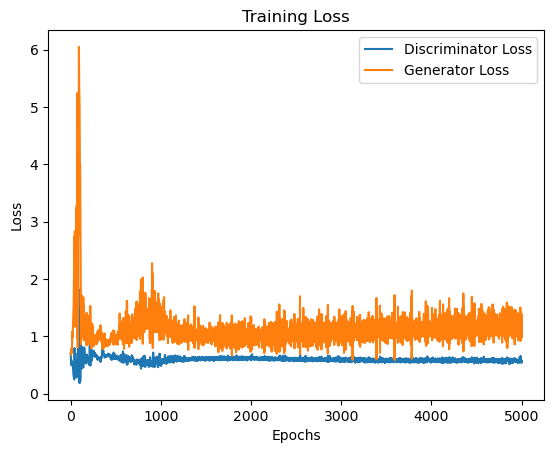

1/1 [==============================] - 0s 94ms/step


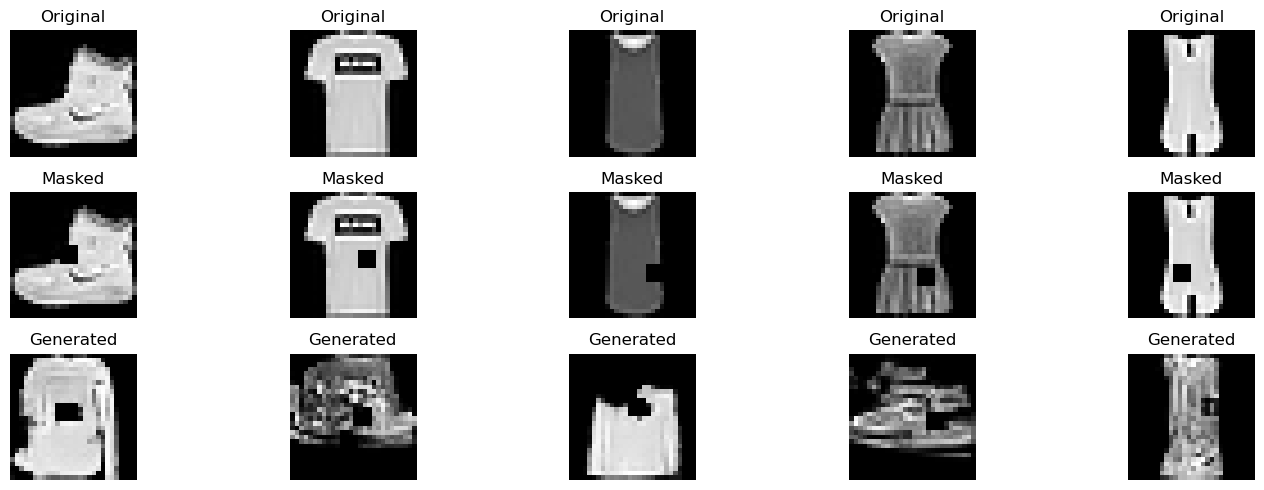

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Flatten, Dense, Reshape, LeakyReLU, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Load Fashion MNIST dataset
(train_images, _), (_, _) = fashion_mnist.load_data()

# Normalize images to range [-1, 1]
train_images = (train_images.astype('float32') - 127.5) / 127.5
train_images = np.expand_dims(train_images, axis=-1)

# Mask some random central regions in images for inpainting
mask_value = -1.0
mask_size = 4
masked_images = np.copy(train_images)
for i in range(len(masked_images)):
    x = np.random.randint(10, 18)
    y = np.random.randint(10, 18)
    masked_images[i, x:x+mask_size, y:y+mask_size, :] = mask_value

# Visualize some masked images
n_samples = 5
plt.figure(figsize=(10, 4))
for i in range(n_samples):
    plt.subplot(2, n_samples, i + 1)
    plt.imshow(masked_images[i, :, :, 0], cmap='gray')
    plt.title('Input (Masked)')
    plt.axis('off')
plt.show()

# Define the input shape
input_shape = (28, 28, 1)

# Encoder
encoder_input = Input(shape=input_shape)
x = Conv2D(32, kernel_size=3, strides=2, padding='same', activation='relu')(encoder_input)
x = Conv2D(64, kernel_size=3, strides=2, padding='same', activation='relu')(x)
x = Flatten()(x)
encoder_output = Dense(64)(x)  # Latent space representation
encoder = Model(encoder_input, encoder_output, name='Encoder')

# Generator (Decoder)
latent_input = Input(shape=(64,))
x = Dense(7*7*64, activation='relu')(latent_input)
x = Reshape((7, 7, 64))(x)
x = Conv2DTranspose(64, kernel_size=3, strides=2, padding='same', activation='relu')(x)
x = Conv2DTranspose(32, kernel_size=3, strides=2, padding='same', activation='relu')(x)
decoder_output = Conv2DTranspose(1, kernel_size=3, padding='same', activation='tanh')(x)
generator = Model(latent_input, decoder_output, name='Generator')

# Discriminator
image_input = Input(shape=input_shape)
x = Conv2D(32, kernel_size=3, strides=2, padding='same', activation='relu')(image_input)
x = Conv2D(64, kernel_size=3, strides=2, padding='same', activation='relu')(x)
x = Flatten()(x)
discriminator_output = Dense(1, activation='sigmoid')(x)
discriminator = Model(image_input, discriminator_output, name='Discriminator')

# Compile discriminator
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5), metrics=['accuracy'])

# Combined GAN model
discriminator.trainable = False
gan_input = Input(shape=(64,))
gan_output = discriminator(generator(gan_input))
gan = Model(gan_input, gan_output, name='GAN')

# Compile GAN
gan.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))

# Training parameters
batch_size = 128
epochs = 5000

# Lists to store loss values
discriminator_losses = []
generator_losses = []

# Training loop
for epoch in range(epochs):
    # Sample random noise
    noise = np.random.normal(0, 1, (batch_size, 64))
    
    # Generate images
    generated_images = generator.predict(noise)
    
    # Select a random batch of real images
    real_images = masked_images[np.random.randint(0, masked_images.shape[0], batch_size)]
    
    # Concatenate real images with generated images
    X = np.concatenate([real_images, generated_images])
    
    # Labels for generated and real images
    y_dis = np.zeros(2*batch_size)
    y_dis[:batch_size] = 0.9  # Label smoothing
    
    # Train discriminator
    discriminator_loss = discriminator.train_on_batch(X, y_dis)
    discriminator_losses.append(discriminator_loss[0])
    
    # Train generator
    noise = np.random.normal(0, 1, (batch_size, 64))
    y_gen = np.ones(batch_size)
    generator_loss = gan.train_on_batch(noise, y_gen)
    generator_losses.append(generator_loss)
    
    # Print progress
    print(f'Epoch {epoch+1}/{epochs}, Discriminator Loss: {discriminator_loss[0]}, Generator Loss: {generator_loss}')

# Plot loss curves
plt.plot(range(1, epochs+1), discriminator_losses, label='Discriminator Loss')
plt.plot(range(1, epochs+1), generator_losses, label='Generator Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss')
plt.show()

# Generate and visualize images
# Generate and visualize images without masked areas
n_samples = 5
noise = np.random.normal(0, 1, (n_samples, 128))
generated_images = generator.predict(noise)

# Define a function to remove the masked area from the original image
def remove_masked_area(original, masked, generated):
    removed_images = []
    for i in range(len(original)):
        mask_indices = np.where(masked[i] != mask_value)
        removed_image = np.copy(original[i])
        removed_image[mask_indices] = generated[i][mask_indices]
        removed_images.append(removed_image)
    return np.array(removed_images)

removed_images = remove_masked_area(train_images[:n_samples], masked_images[:n_samples], generated_images)

# Visualize the original images and the generated images without masked areas
# Visualize original, masked, and generated images
plt.figure(figsize=(15, 5))
for i in range(n_samples):
    plt.subplot(3, n_samples, i + 1)
    plt.imshow(train_images[i, :, :, 0], cmap='gray')
    plt.title('Original')
    plt.axis('off')
    plt.subplot(3, n_samples, n_samples + i + 1)
    plt.imshow(masked_images[i, :, :, 0], cmap='gray')
    plt.title('Masked')
    plt.axis('off')
    plt.subplot(3, n_samples, 2*n_samples + i + 1)
    plt.imshow(generated_images[i, :, :, 0], cmap='gray')
    plt.title('Generated')
    plt.axis('off')
plt.tight_layout()
plt.show()




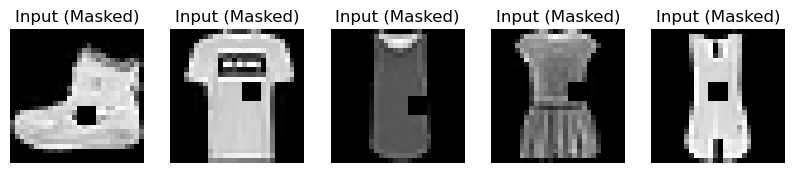

9/9 [==============================] - 0s 10ms/step
Epoch 1/5000, Discriminator Loss: 0.6981225609779358, Generator Loss: 0.6931554675102234
9/9 [==============================] - 0s 7ms/step
Epoch 2/5000, Discriminator Loss: 0.6565489172935486, Generator Loss: 0.686374306678772
9/9 [==============================] - 0s 7ms/step
Epoch 3/5000, Discriminator Loss: 0.6217802166938782, Generator Loss: 0.6637970805168152
9/9 [==============================] - 0s 7ms/step
Epoch 4/5000, Discriminator Loss: 0.601215660572052, Generator Loss: 0.6163138151168823
9/9 [==============================] - 0s 8ms/step
Epoch 5/5000, Discriminator Loss: 0.6140738725662231, Generator Loss: 0.5781853199005127
9/9 [==============================] - 0s 7ms/step
Epoch 6/5000, Discriminator Loss: 0.6460137963294983, Generator Loss: 0.5821114778518677
9/9 [==============================] - 0s 7ms/step
Epoch 7/5000, Discriminator Loss: 0.6409215927124023, Generator Loss: 0.6269229650497437
9/9 [================

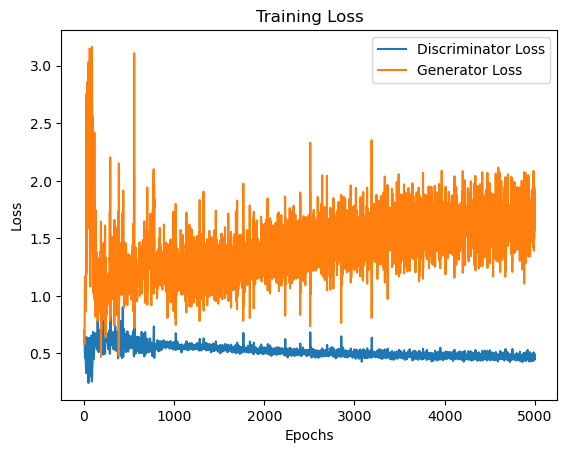

1/1 [==============================] - 0s 47ms/step


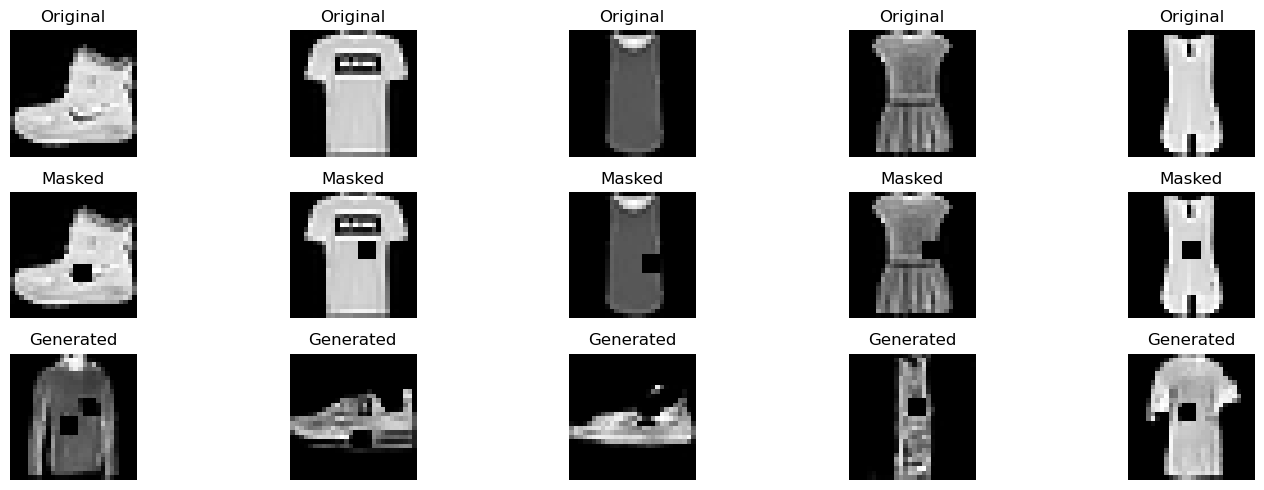

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Flatten, Dense, Reshape, LeakyReLU, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Load Fashion MNIST dataset
(train_images, _), (_, _) = fashion_mnist.load_data()

# Normalize images to range [-1, 1]
train_images = (train_images.astype('float32') - 127.5) / 127.5
train_images = np.expand_dims(train_images, axis=-1)

# Mask some random central regions in images for inpainting
mask_value = -1.0
mask_size = 4
masked_images = np.copy(train_images)
for i in range(len(masked_images)):
    x = np.random.randint(10, 18)
    y = np.random.randint(10, 18)
    masked_images[i, x:x+mask_size, y:y+mask_size, :] = mask_value

# Visualize some masked images
n_samples = 5
plt.figure(figsize=(10, 4))
for i in range(n_samples):
    plt.subplot(2, n_samples, i + 1)
    plt.imshow(masked_images[i, :, :, 0], cmap='gray')
    plt.title('Input (Masked)')
    plt.axis('off')
plt.show()

# Define the input shape
input_shape = (28, 28, 1)

# Encoder
encoder_input = Input(shape=input_shape)
x = Conv2D(32, kernel_size=3, strides=2, padding='same', activation='relu')(encoder_input)
x = Conv2D(64, kernel_size=3, strides=2, padding='same', activation='relu')(x)
x = Conv2D(128, kernel_size=3, strides=2, padding='same', activation='relu')(x)
x = Flatten()(x)
encoder_output = Dense(64)(x)  # Latent space representation
encoder = Model(encoder_input, encoder_output, name='Encoder')

# Generator (Decoder)
latent_input = Input(shape=(64,))
x = Dense(7*7*128, activation='relu')(latent_input)
x = Reshape((7, 7, 128))(x)
x = Conv2DTranspose(64, kernel_size=3, strides=2, padding='same', activation='relu')(x)
x = Conv2DTranspose(32, kernel_size=3, strides=2, padding='same', activation='relu')(x)
decoder_output = Conv2DTranspose(1, kernel_size=3, padding='same', activation='tanh')(x)
generator = Model(latent_input, decoder_output, name='Generator')

# Discriminator
image_input = Input(shape=input_shape)
x = Conv2D(32, kernel_size=3, strides=2, padding='same', activation='relu')(image_input)
x = Conv2D(64, kernel_size=3, strides=2, padding='same', activation='relu')(x)
x = Conv2D(128, kernel_size=3, strides=2, padding='same', activation='relu')(x)
x = Flatten()(x)
discriminator_output = Dense(1, activation='sigmoid')(x)
discriminator = Model(image_input, discriminator_output, name='Discriminator')

# Compile discriminator
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.00005, beta_1=0.6), metrics=['accuracy'])

# Combined GAN model
discriminator.trainable = False
gan_input = Input(shape=(64,))
gan_output = discriminator(generator(gan_input))
gan = Model(gan_input, gan_output, name='GAN')

# Compile GAN
gan.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.00005, beta_1=0.6))

# Training parameters
batch_size = 264
epochs = 5000

# Lists to store loss values
discriminator_losses = []
generator_losses = []

# Training loop
for epoch in range(epochs):
    # Sample random noise
    noise = np.random.normal(0, 1, (batch_size, 64))
    
    # Generate images
    generated_images = generator.predict(noise)
    
    # Select a random batch of real images
    real_images = masked_images[np.random.randint(0, masked_images.shape[0], batch_size)]
    
    # Concatenate real images with generated images
    X = np.concatenate([real_images, generated_images])
    
    # Labels for generated and real images
    y_dis = np.zeros(2*batch_size)
    y_dis[:batch_size] = 0.9  # Label smoothing
    
    # Train discriminator
    discriminator_loss = discriminator.train_on_batch(X, y_dis)
    discriminator_losses.append(discriminator_loss[0])
    
    # Train generator
    noise = np.random.normal(0, 1, (batch_size, 64))
    y_gen = np.ones(batch_size)
    generator_loss = gan.train_on_batch(noise, y_gen)
    generator_losses.append(generator_loss)
    
    # Print progress
    print(f'Epoch {epoch+1}/{epochs}, Discriminator Loss: {discriminator_loss[0]}, Generator Loss: {generator_loss}')

# Plot loss curves
plt.plot(range(1, epochs+1), discriminator_losses, label='Discriminator Loss')
plt.plot(range(1, epochs+1), generator_losses, label='Generator Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss')
plt.show()

# Generate and visualize images
n_samples = 5
noise = np.random.normal(0, 1, (n_samples, 64))
generated_images = generator.predict(noise)


plt.figure(figsize=(15, 5))
for i in range(n_samples):
    plt.subplot(3, n_samples, i + 1)
    plt.imshow(train_images[i, :, :, 0], cmap='gray')
    plt.title('Original')
    plt.axis('off')
    plt.subplot(3, n_samples, n_samples + i + 1)
    plt.imshow(masked_images[i, :, :, 0], cmap='gray')
    plt.title('Masked')
    plt.axis('off')
    plt.subplot(3, n_samples, 2*n_samples + i + 1)
    plt.imshow(generated_images[i, :, :, 0], cmap='gray')
    plt.title('Generated')
    plt.axis('off')
plt.tight_layout()
plt.show()


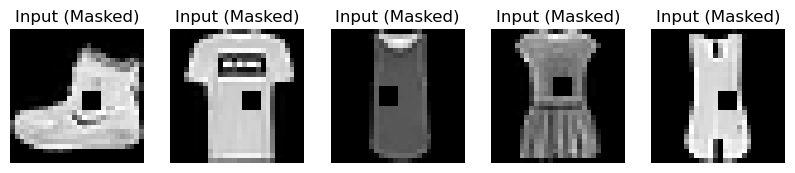

9/9 [==============================] - 0s 9ms/step
Epoch 1/50, Discriminator Loss: 0.5213831632935528, Generator Loss: 1.6654223902109961
9/9 [==============================] - 0s 7ms/step
Epoch 2/50, Discriminator Loss: 0.622328101800927, Generator Loss: 1.1689122613306087
9/9 [==============================] - 0s 9ms/step
Epoch 3/50, Discriminator Loss: 0.5896495638439834, Generator Loss: 1.313795687081005
9/9 [==============================] - 0s 8ms/step
Epoch 4/50, Discriminator Loss: 0.5828460118844121, Generator Loss: 1.3145387879027144
9/9 [==============================] - 0s 9ms/step
Epoch 5/50, Discriminator Loss: 0.5652249955658345, Generator Loss: 1.2749543108604027
9/9 [==============================] - 0s 10ms/step
Epoch 6/50, Discriminator Loss: 0.5735994939762065, Generator Loss: 1.2091574041328765
9/9 [==============================] - 0s 12ms/step
Epoch 7/50, Discriminator Loss: 0.567214942188515, Generator Loss: 1.1933725363357477
9/9 [==============================

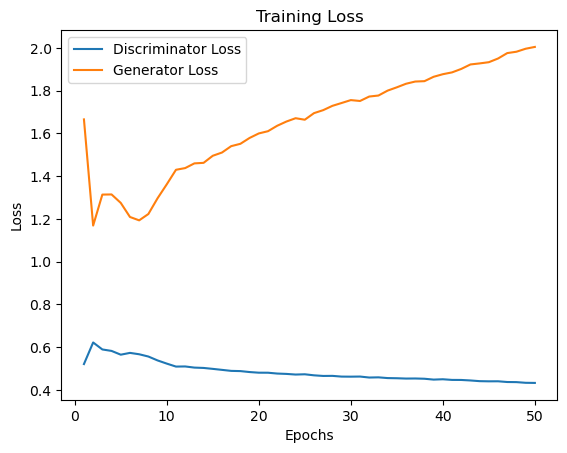

1/1 [==============================] - 0s 35ms/step


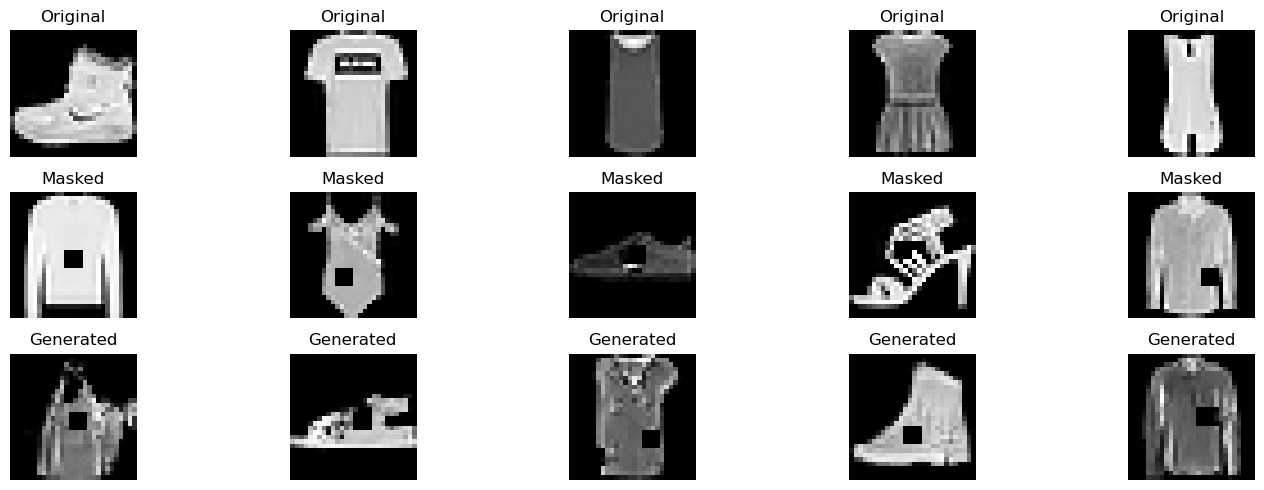

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Flatten, Dense, Reshape, LeakyReLU, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Load Fashion MNIST dataset
(train_images, _), (_, _) = fashion_mnist.load_data()

# Normalize images to range [-1, 1]
train_images = (train_images.astype('float32') - 127.5) / 127.5
train_images = np.expand_dims(train_images, axis=-1)

# Mask some random central regions in images for inpainting
mask_value = -1.0
mask_size = 4
masked_images = np.copy(train_images)
for i in range(len(masked_images)):
    x = np.random.randint(10, 18)
    y = np.random.randint(10, 18)
    masked_images[i, x:x+mask_size, y:y+mask_size, :] = mask_value

# Visualize some masked images
n_samples = 5
plt.figure(figsize=(10, 4))
for i in range(n_samples):
    plt.subplot(2, n_samples, i + 1)
    plt.imshow(masked_images[i, :, :, 0], cmap='gray')
    plt.title('Input (Masked)')
    plt.axis('off')
plt.show()

# Define the input shape
input_shape = (28, 28, 1)

# Encoder
encoder_input = Input(shape=input_shape)
x = Conv2D(32, kernel_size=3, strides=2, padding='same', activation='relu')(encoder_input)
x = Conv2D(64, kernel_size=3, strides=2, padding='same', activation='relu')(x)
x = Conv2D(128, kernel_size=3, strides=2, padding='same', activation='relu')(x)
x = Flatten()(x)
encoder_output = Dense(64)(x)  # Latent space representation
encoder = Model(encoder_input, encoder_output, name='Encoder')

# Generator (Decoder)
latent_input = Input(shape=(64,))
x = Dense(7*7*128, activation='relu')(latent_input)
x = Reshape((7, 7, 128))(x)
x = Conv2DTranspose(64, kernel_size=3, strides=2, padding='same', activation='relu')(x)
x = Conv2DTranspose(32, kernel_size=3, strides=2, padding='same', activation='relu')(x)
decoder_output = Conv2DTranspose(1, kernel_size=3, padding='same', activation='tanh')(x)
generator = Model(latent_input, decoder_output, name='Generator')

# Discriminator
image_input = Input(shape=input_shape)
x = Conv2D(32, kernel_size=3, strides=2, padding='same', activation='relu')(image_input)
x = Conv2D(64, kernel_size=3, strides=2, padding='same', activation='relu')(x)
x = Conv2D(128, kernel_size=3, strides=2, padding='same', activation='relu')(x)
x = Flatten()(x)
discriminator_output = Dense(1, activation='sigmoid')(x)
discriminator = Model(image_input, discriminator_output, name='Discriminator')

# Compile discriminator
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.00005, beta_1=0.6), metrics=['accuracy'])

# Combined GAN model
discriminator.trainable = False
gan_input = Input(shape=(64,))
gan_output = discriminator(generator(gan_input))
gan = Model(gan_input, gan_output, name='GAN')

# Compile GAN
gan.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.00005, beta_1=0.6))

batch_size = 264
epochs = 50

# Lists to store loss values
discriminator_losses = []
generator_losses = []

# Calculate the number of batches per epoch
num_batches_per_epoch = len(masked_images) // batch_size

# Training loop
for epoch in range(epochs):
    # Shuffle the dataset
    np.random.shuffle(masked_images)
    
    # Initialize running loss
    running_discriminator_loss = 0.0
    running_generator_loss = 0.0
    
    # Iterate over batches
    for batch_idx in range(num_batches_per_epoch):
        # Sample random noise
        noise = np.random.normal(0, 1, (batch_size, 64))
        
        # Generate images
        generated_images = generator.predict(noise)
        
        # Select a random batch of real images
        start_idx = batch_idx * batch_size
        end_idx = (batch_idx + 1) * batch_size
        real_images = masked_images[start_idx:end_idx]
        
        # Concatenate real images with generated images
        X = np.concatenate([real_images, generated_images])
        
        # Labels for generated and real images
        y_dis = np.zeros(2 * batch_size)
        y_dis[:batch_size] = 0.9  # Label smoothing
        
        # Train discriminator
        discriminator_loss = discriminator.train_on_batch(X, y_dis)
        running_discriminator_loss += discriminator_loss[0]
        
        # Train generator
        noise = np.random.normal(0, 1, (batch_size, 64))
        y_gen = np.ones(batch_size)
        generator_loss = gan.train_on_batch(noise, y_gen)
        running_generator_loss += generator_loss
    
    # Calculate average loss for the epoch
    epoch_discriminator_loss = running_discriminator_loss / num_batches_per_epoch
    epoch_generator_loss = running_generator_loss / num_batches_per_epoch
    
    discriminator_losses.append(epoch_discriminator_loss)
    generator_losses.append(epoch_generator_loss)
    
    # Print progress
    print(f'Epoch {epoch+1}/{epochs}, Discriminator Loss: {epoch_discriminator_loss}, Generator Loss: {epoch_generator_loss}')

# Plot loss curves
plt.plot(range(1, epochs+1), discriminator_losses, label='Discriminator Loss')
plt.plot(range(1, epochs+1), generator_losses, label='Generator Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss')
plt.show()

# Generate and visualize images
n_samples = 5
noise = np.random.normal(0, 1, (n_samples, 64))
generated_images = generator.predict(noise)


plt.figure(figsize=(15, 5))
for i in range(n_samples):
    plt.subplot(3, n_samples, i + 1)
    plt.imshow(train_images[i, :, :, 0], cmap='gray')
    plt.title('Original')
    plt.axis('off')
    plt.subplot(3, n_samples, n_samples + i + 1)
    plt.imshow(masked_images[i, :, :, 0], cmap='gray')
    plt.title('Masked')
    plt.axis('off')
    plt.subplot(3, n_samples, 2*n_samples + i + 1)
    plt.imshow(generated_images[i, :, :, 0], cmap='gray')
    plt.title('Generated')
    plt.axis('off')
plt.tight_layout()
plt.show()


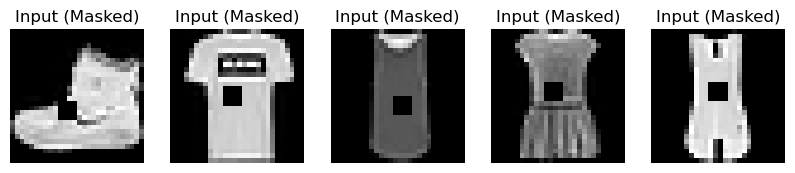

9/9 [==============================] - 0s 21ms/step


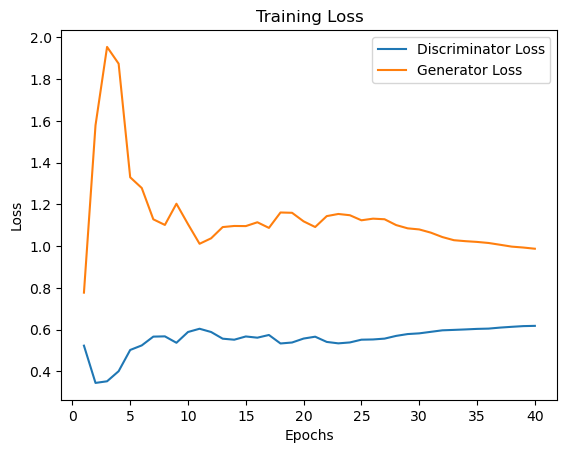

1/1 [==============================] - 0s 73ms/step


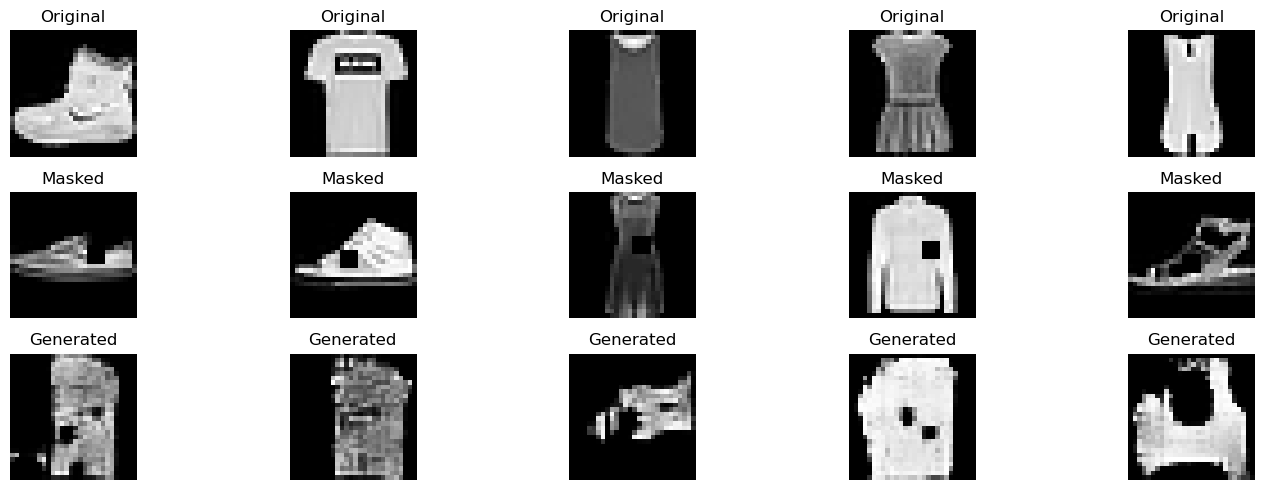

In [15]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Flatten, Dense, Reshape, LeakyReLU, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Load Fashion MNIST dataset
(train_images, _), (_, _) = fashion_mnist.load_data()

# Normalize images to range [-1, 1]
train_images = (train_images.astype('float32') - 127.5) / 127.5
train_images = np.expand_dims(train_images, axis=-1)

# Mask some random central regions in images for inpainting
mask_value = -1.0
mask_size = 4
masked_images = np.copy(train_images)
for i in range(len(masked_images)):
    x = np.random.randint(10, 18)
    y = np.random.randint(10, 18)
    masked_images[i, x:x+mask_size, y:y+mask_size, :] = mask_value

# Visualize some masked images
n_samples = 5
plt.figure(figsize=(10, 4))
for i in range(n_samples):
    plt.subplot(2, n_samples, i + 1)
    plt.imshow(masked_images[i, :, :, 0], cmap='gray')
    plt.title('Input (Masked)')
    plt.axis('off')
plt.show()

# Define the input shape
input_shape = (28, 28, 1)

# Encoder
encoder_input = Input(shape=input_shape)
x = Conv2D(32, kernel_size=3, strides=2, padding='same', activation='relu')(encoder_input)
x = Conv2D(64, kernel_size=3, strides=2, padding='same', activation='relu')(x)
x = Conv2D(128, kernel_size=3, strides=2, padding='same', activation='relu')(x)
x = Flatten()(x)
encoder_output = Dense(64)(x)  # Latent space representation
encoder = Model(encoder_input, encoder_output, name='Encoder')

# Generator (Decoder)
latent_input = Input(shape=(64,))
x = Dense(7*7*128, activation='relu')(latent_input)
x = Reshape((7, 7, 128))(x)
x = Conv2DTranspose(64, kernel_size=3, strides=2, padding='same', activation='relu')(x)
x = Conv2DTranspose(32, kernel_size=3, strides=2, padding='same', activation='relu')(x)
decoder_output = Conv2DTranspose(1, kernel_size=3, padding='same', activation='tanh')(x)
generator = Model(latent_input, decoder_output, name='Generator')

# Discriminator
image_input = Input(shape=input_shape)
x = Conv2D(32, kernel_size=3, strides=2, padding='same', activation='relu')(image_input)
x = Conv2D(64, kernel_size=3, strides=2, padding='same', activation='relu')(x)
x = Conv2D(128, kernel_size=3, strides=2, padding='same', activation='relu')(x)
x = Flatten()(x)
discriminator_output = Dense(1, activation='sigmoid')(x)
discriminator = Model(image_input, discriminator_output, name='Discriminator')

# Compile discriminator
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.00005, beta_1=0.6), metrics=['accuracy'])

# Combined GAN model
discriminator.trainable = False
gan_input = Input(shape=(64,))
gan_output = discriminator(generator(gan_input))
gan = Model(gan_input, gan_output, name='GAN')

# Compile GAN
gan.compile(loss=['binary_crossentropy', inpainting_losses], optimizer=Adam(learning_rate=0.00005, beta_1=0.6))

batch_size = 264
epochs = 40

# Lists to store loss values
discriminator_losses = []
generator_losses = []
inpainting_losses = []

# Calculate the number of batches per epoch
num_batches_per_epoch = len(masked_images) // batch_size

# Training loop
for epoch in range(epochs):
    # Shuffle the dataset
    np.random.shuffle(masked_images)
    
    # Initialize running loss
    running_discriminator_loss = 0.0
    running_generator_loss = 0.0
    running_inpainting_loss = 0.0
    
    # Iterate over batches
    for batch_idx in range(num_batches_per_epoch):
        # Sample random noise
        noise = np.random.normal(0, 1, (batch_size, 64))
        
        # Generate images
        generated_images = generator.predict(noise)
        
        # Select a random batch of real images
        start_idx = batch_idx * batch_size
        end_idx = (batch_idx + 1) * batch_size
        real_images = masked_images[start_idx:end_idx]
        
        # Concatenate real images with generated images
        X = np.concatenate([real_images, generated_images])
        
        # Labels for generated and real images
        y_dis = np.zeros(2 * batch_size)
        y_dis[:batch_size] = 0.9  # Label smoothing
        
        # Train discriminator
        discriminator_loss = discriminator.train_on_batch(X, y_dis)
        running_discriminator_loss += discriminator_loss[0]
        
        # Train generator
        noise = np.random.normal(0, 1, (batch_size, 64))
        y_gen = np.ones(batch_size)
        combined_loss = gan.train_on_batch(noise, [y_gen, real_images])
        generator_loss = combined_loss 
        inpainting_loss = 0.0 
        running_generator_loss += generator_loss
        running_inpainting_loss += inpainting_loss
    
    # Calculate average loss for the epoch
    epoch_discriminator_loss = running_discriminator_loss / num_batches_per_epoch
    epoch_generator_loss = running_generator_loss / num_batches_per_epoch
    epoch_inpainting_loss = running_inpainting_loss / num_batches_per_epoch
    
    discriminator_losses.append(epoch_discriminator_loss)
    generator_losses.append(epoch_generator_loss)
    inpainting_losses.append(epoch_inpainting_loss)
    
    # Print progress
    print(f'Epoch {epoch+1}/{epochs}, Discriminator Loss: {epoch_discriminator_loss}, Generator Loss: {epoch_generator_loss}, Inpainting Loss: {epoch_inpainting_loss}')

# Plot loss curves
plt.plot(range(1, epochs+1), discriminator_losses, label='Discriminator Loss')
plt.plot(range(1, epochs+1), generator_losses, label='Generator Loss')
#plt.plot(range(1, epochs+1), inpainting_losses, label='Inpainting Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss')
plt.show()

# Generate and visualize images
n_samples = 5
noise = np.random.normal(0, 1, (n_samples, 64))
generated_images = generator.predict(noise)

plt.figure(figsize=(15, 5))
for i in range(n_samples):
    plt.subplot(3, n_samples, i + 1)
    plt.imshow(train_images[i, :, :, 0], cmap='gray')
    plt.title('Original')
    plt.axis('off')
    plt.subplot(3, n_samples, n_samples + i + 1)
    plt.imshow(masked_images[i, :, :, 0], cmap='gray')
    plt.title('Masked')
    plt.axis('off')
    plt.subplot(3, n_samples, 2*n_samples + i + 1)
    plt.imshow(generated_images[i, :, :, 0], cmap='gray')
    plt.title('Generated')
    plt.axis('off')
plt.tight_layout()
plt.show()
